# Testing MPO

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [2]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 11
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, DGLOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    'CASP3 affinity',
    receptor_path=f'{path}/dockstring_targets/CASP3_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create evaluators
docking_cost_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(8, 9.5),
    acceptable=(7.7, 9.5)
)

log_P_cost_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 2),
    acceptable=(-0.5, 3.5)
)

log_S_cost_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-2, 1),
    acceptable=(-4, 1)
)

assays = [docking_oracle, log_P_oracle, log_S_oracle]
cost_functions = [docking_cost_function, log_P_cost_function, log_S_cost_function]

Instantiate designer.

In [3]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [4]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [5]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(costs):

    # Multi-dimensional non-dominated fusion sort
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks]) # prioritizes last column
    
    return fused_ranks.tolist()

Multi-step selection.

In [6]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

costs = np.asarray([cost(library) for cost in cost_functions]).T
ranking = rank_molecules(costs)
best = ranking[0]

best = [np.nanargmax(docking_oracle(library)).item()]
print([cost(library[best]) for cost in cost_functions])
print(best)

for step in tqdm(range(1, 30)):
    
    analogs = []
    for b in best:
        if step % 3 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=0.5)

    # Get costs
    library += analogs
    
    if step < 8:
        costs = docking_cost_function(library).reshape(-1, 1)
    else:
        costs = np.asarray([cost(library) for cost in cost_functions]).T
        
    ranking = rank_molecules(costs)
    best = ranking[:5]
    # best = np.random.choice(len(costs))

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, costs[best])
    print(step, best)

[array([13.49934082]), array([0.0162]), array([0.80834258])]
[1]


  0%|          | 0/29 [00:00<?, ?it/s]

1 [[ 5.50404223]
 [ 8.33263896]
 [ 9.6309872 ]
 [11.86618024]
 [13.49934082]]
1 [7, 6, 8, 12, 1]
2 [[4.47326234]
 [5.33289993]
 [5.50404223]
 [5.65164818]
 [5.77996706]]
2 [23, 28, 7, 15, 16]
3 [[3.36144075]
 [3.83100958]
 [3.98300411]
 [4.13345344]
 [4.47326234]]
3 [73, 88, 86, 60, 23]
4 [[3.02498277]
 [3.34670348]
 [3.36144075]
 [3.83100958]
 [3.98300411]]
4 [115, 128, 73, 88, 86]
5 [[3.02498277]
 [3.34670348]
 [3.36144075]
 [3.59151048]
 [3.83100958]]
5 [115, 128, 73, 155, 88]
6 [[1.80831042]
 [2.29811269]
 [2.49919083]
 [3.02498277]
 [3.08817351]]
6 [191, 184, 187, 115, 210]
7 [[1.17544899]
 [1.80831042]
 [2.29811269]
 [2.41613227]
 [2.49091133]]
7 [231, 191, 184, 214, 227]
8 [[6.50981566 0.         0.91297102]
 [2.69298529 1.34467216 3.61041532]
 [4.13345344 0.098      5.43218879]
 [8.70616211 0.21126667 0.87936294]
 [5.35106817 0.25708    4.29795158]]
8 [29, 216, 60, 50, 126]


Exception: `route` must include a reaction or reactants.

# Visualizing results

Text(0.5, 1.0, 'Heavy atom count vs. pIC50')

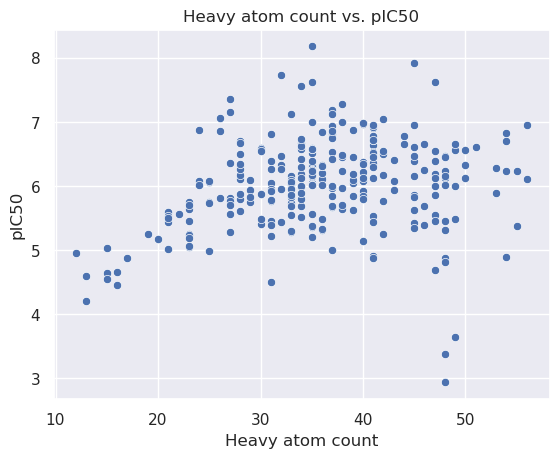

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')

In [8]:
records = []
docking_scores = docking_oracle(library)
logP_scores = log_P_oracle(library)
lle_scores = np.array(docking_scores) - np.array(logP_scores)
for idx, (mol, score, lle, logP) in enumerate(zip(library, docking_scores, lle_scores, logP_scores)):
    records.append(
        {'pIC50': score,
         'LLE': lle,
         'log P': logP,
         'timestep': 1 + ((idx - 5) // 20)})

import pandas as pd
df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


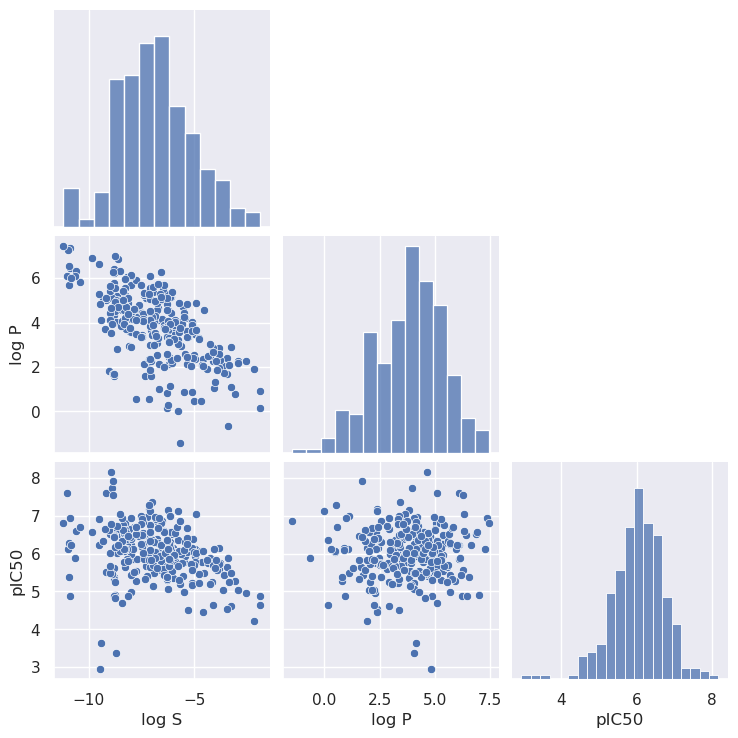

In [9]:
sns.pairplot(
    pd.DataFrame([{'log S': log_S_oracle(l)[0],
                   'log P': log_P_oracle(l)[0],
                   'pIC50': docking_oracle(l)[0]} for l in library]),
    corner=True
)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


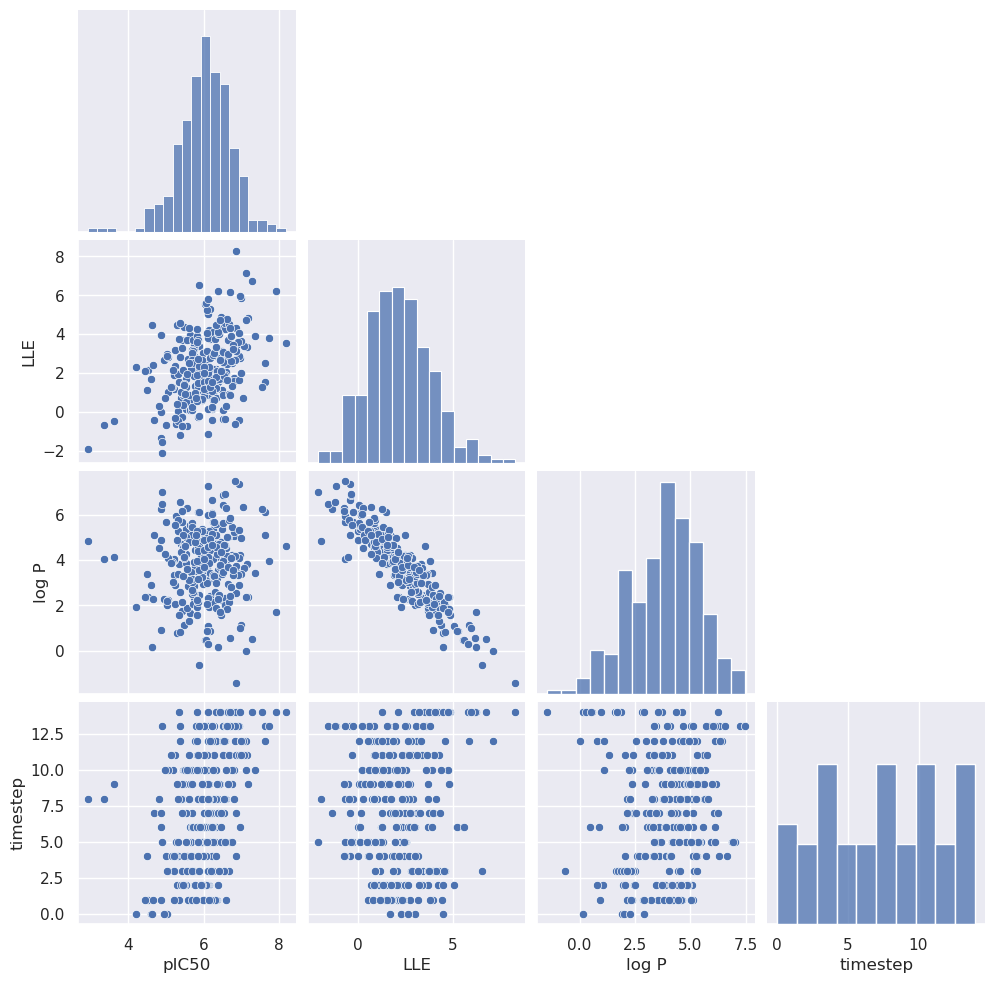

In [10]:
sns.pairplot(df, corner=True)

## Visualizing the best across rounds

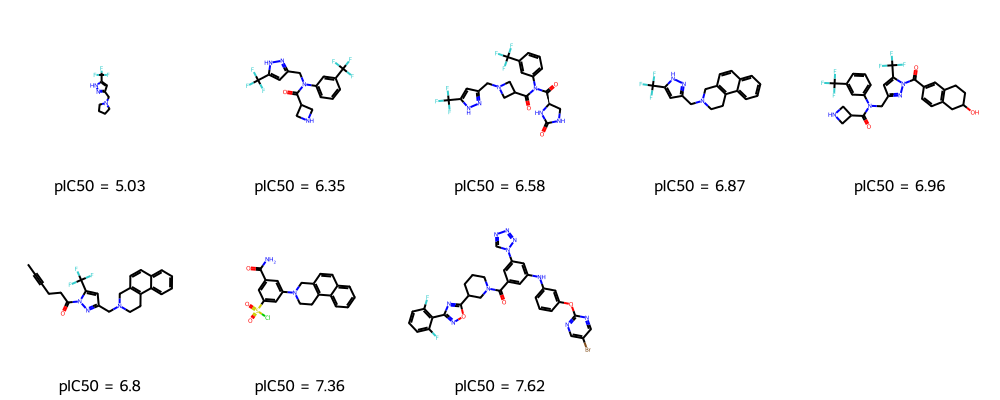

In [11]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')['CASP3 affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')['CASP3 affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx]['CASP3 affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

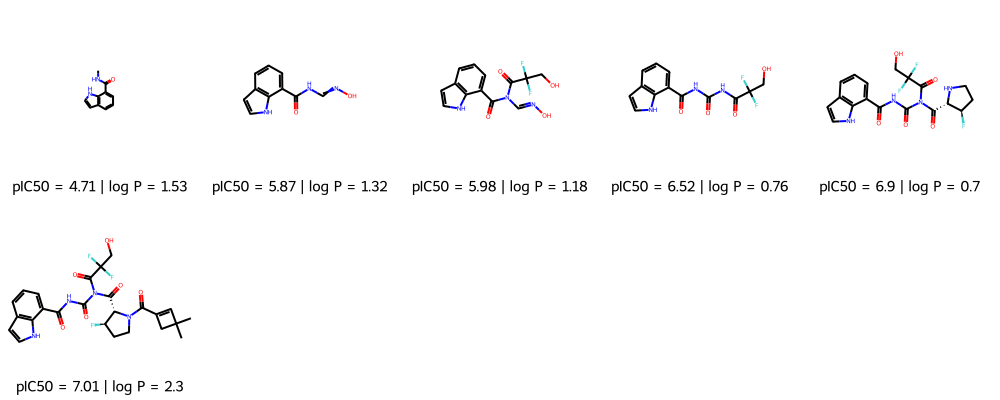

In [684]:
mol = library[np.nanargmax(docking_oracle(library)).item()]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))

MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

Text(0.5, 1.0, 'New compounds synthesized each round')

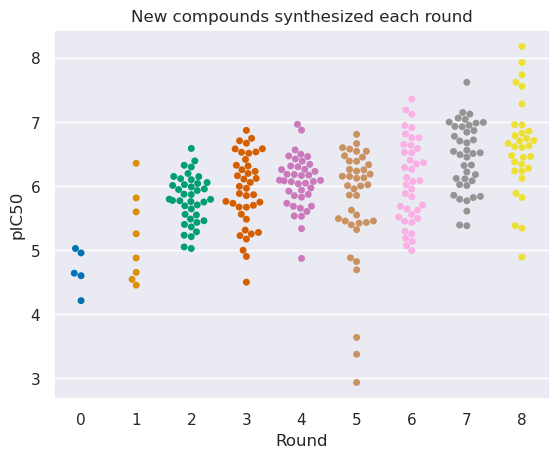

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

objective = 'CASP3 affinity'
annotations = library.annotations
annotations[objective] = [l[0] for l in annotations[objective]]

sns.swarmplot(
    annotations,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [13]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in library.annotations.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {'pIC50': mol['CASP3 affinity'][0], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

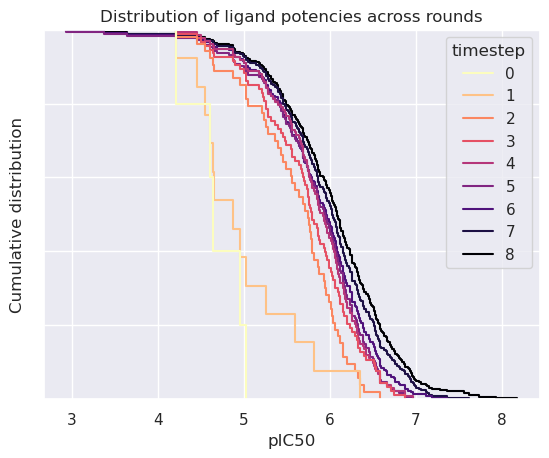

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

g = sns.ecdfplot(
    df,
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

In [18]:
library.annotations.sort_values(by='CASP3 affinity')

,HBA,TPSA,RotBonds,reagsmi1,reagsmi2,reag1,Catalog ID,MW,MW (desalted),ClogP,...,reaction,RDB type,smiles,design_cycle,reactants,timestep,CASP3 affinity,MolLogP,GCN_canonical_ESOL,inspiration
161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C1COc2cc(F)c(C(=O)N(C(=O)C3CN(Cc4cc(C(F)(F)F...,4,[O=C1COc2cc(F)c(C(=O)N(C(=O)C3CN(Cc4cc(C(F)(F)...,5,[2.9370331637032887],[4.8411000000000035],[-9.48652172088623],O=C1COc2cc(F)c(C(=O)N(C(=O)C3CN(Cc4cc(C(F)(F)F...
158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,CN1CC[C@H]1C(=O)n1nc(CN2CC(C(=O)N(C(=O)c3cc4c(...,4,[O=C1COc2cc(F)c(C(=O)N(C(=O)C3CN(Cc4cc(C(F)(F)...,5,[3.3765527443168906],[4.040400000000003],[-8.698948860168457],O=C1COc2cc(F)c(C(=O)N(C(=O)C3CN(Cc4cc(C(F)(F)F...
170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C1COc2cc(F)c(C(=O)n3nc(CN4CC(C(=O)N(C(=O)c5c...,4,[O=C1COc2cc(F)c(C(=O)n3nc(CN4CC(C(=O)Nc5cccc(C...,5,[3.639894779429862],[4.134400000000003],[-9.426471710205078],O=C1COc2cc(F)c(C(=O)n3nc(CN4CC(C(=O)Nc5cccc(C(...
0,2.0,32.26,4.0,CC(C)(N)CO,CC=1C=CSC1C=O,EN300-19785,Z57328552,199.103,199.313,1.721,...,REDUCTION,sRDB,Cc1ccsc1CNC(C)(C)CO,0,"[CC(C)(N)CO, Cc1ccsc1C=O]",0,[4.21249535560441],[1.9170199999999995],[-2.143449068069458],NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=S(=O)(Cl)c1c(Br)cncc1N1CCCC1,1,"[C1CCNC1, O=S(=O)(Cl)c1c(Cl)cncc1Br]",1,[4.4543014688899065],[2.3718000000000004],[-4.557485580444336],FC(F)(F)c1cc(CN2CCCC2)n[nH]1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C(c1cc(Nc2cccc(Oc3ncc(Br)cn3)c2)cc(-n2cnnn2)...,5,[O=C(O)c1cc(Nc2cccc(Oc3ncc(Br)cn3)c2)cc(-n2cnn...,7,[7.615818748109259],[6.0987000000000045],[-11.055570602416992],O=C(O)[C@H]1CNC(=O)N1C(=O)c1cc(Nc2cccc(Oc3ncc(...
262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C(NC(=O)c1csc(F)c1)c1cc(N2CCc3c(ccc4ccccc34)...,4,[NC(=O)c1cc(N2CCc3c(ccc4ccccc34)C2)cc(S(=O)(=O...,8,[7.61593194403043],[5.100800000000004],[-9.192015647888184],NC(=O)c1cc(N2CCc3c(ccc4ccccc34)C2)cc(S(=O)(=O)...
264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C(C#CBr)NC(=O)c1cc(N2CCc3c(ccc4ccccc34)C2)cc...,4,[NC(=O)c1cc(N2CCc3c(ccc4ccccc34)C2)cc(S(=O)(=O...,8,[7.733732967185381],[3.9422000000000033],[-8.88988208770752],NC(=O)c1cc(N2CCc3c(ccc4ccccc34)C2)cc(S(=O)(=O)...
275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,O=C(NC(=O)C12CC(CN1)C2)[C@H]1CN(C(=O)c2cc(Nc3c...,5,[O=C(O)[C@H]1CN(C(=O)c2cc(Nc3cccc(Oc4ncc(Br)cn...,8,[7.924874095034778],[1.6794999999999993],[-8.861379623413086],O=C(O)[C@H]1CN(C(=O)c2cc(Nc3cccc(Oc4ncc(Br)cn4...


In [16]:
num_fronts = 10
utility_fns = ['log S', 'log P', 'pIC50']

records = []
records_merged = []
for idx, mol in enumerate(nds[:num_fronts]):
    score = scores[jdx]
    for adx, value in enumerate(score):
        records_merged.append({
            'property value (pIC50, logS, logP)': value,
            'assay': cost_functions[adx],
            'front': idx,
        })

    record = {name: value for (name, value) in zip(utility_fns, score)}
    record.update({'front': idx})
    records.append(record)

df = pd.DataFrame(records)
df_merged = pd.DataFrame(records_merged)

plt.fill_betweenx(log_S_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)
plt.fill_betweenx(log_P_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)
plt.fill_betweenx(docking_utility_function.ideal, -1, num_fronts, alpha=0.2, zorder=-10)

g = sns.stripplot(
    df_merged,
    x='front',
    y='property value (pIC50, logS, logP)',
    hue='assay',
)

# Put the legend out of the figure
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# g.set_ybound(-6, 10)

plt.title('Non-dominated sorting fronts with a multi-objective function')

NameError: name 'nds' is not defined

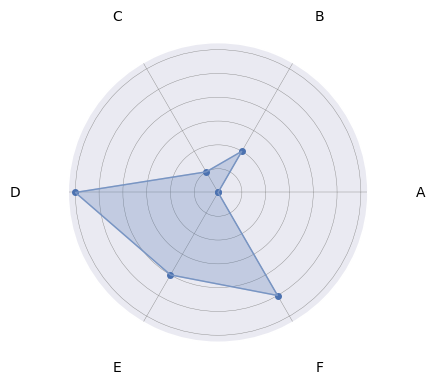

In [23]:
import matplotlib.pyplot as plt

from radar import radar_chart

labels = ["A", "B", "C", "D", "E", "F"]
values = [0, 2, 1, 6, 4, 5]

radar_chart(labels=labels, values=values)
plt.show()

In [37]:
library.annotations

TypeError: create_block_manager_from_column_arrays() got an unexpected keyword argument 'refs'

In [36]:
from pycirclize import Circos
import pandas as pd

# # Create RPG jobs parameter dataframe (3 jobs, 7 parameters)
# df = pd.DataFrame(
#     data=[
#         [80, 80, 80, 80, 80, 80, 80],
#         [90, 20, 95, 95, 30, 30, 80],
#         [60, 90, 20, 20, 100, 90, 50],
#     ],
#     index=["Hero", "Warrior", "Wizard"],
#     columns=["HP", "MP", "ATK", "DEF", "SP.ATK", "SP.DEF", "SPD"],
# )

# Initialize Circos instance for radar chart plot
circos = Circos.radar_chart(
    library.annotations,
    vmax=100,
    marker_size=6,
    grid_interval_ratio=0.2,
)

# # Plot figure & set legend on upper right
# fig = circos.plotfig()
# _ = circos.ax.legend(loc="upper right", fontsize=10)

TypeError: create_block_manager_from_column_arrays() got an unexpected keyword argument 'refs'